In [1]:
import numpy as np
import pandas as pd
import os
import os.path as osp
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import time
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

from bi_tempered_loss_pytorch import bi_tempered_logistic_loss

In [2]:
seed = 334

num_folds = 5

rootpath = osp.join('..','input','cassava-leaf-disease-classification')

# size, mean, std
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model_name = 'resnet50'

# loss_name = 'CrossEntropyLoss'
loss_name = 'BiTemperedLogisticLoss'
loss_params = {
    't1': 0.2,
    't2': 1.2,
    'label_smoothing': 0.01,
    'num_iters': 5,
    'reduction': 'mean'
}

# mini-batch size
batch_size = 3

# number of epochs
num_epochs = 5

set_all = True

In [3]:
train = pd.read_csv(osp.join(rootpath, 'train.csv'))
train['image_path'] = osp.join(rootpath, 'train_images')
train['image_path'] = train['image_path'].str.cat(train['image_id'], sep=osp.sep)
train.head()

,image_id,label,image_path
0,1000015157.jpg,0,..\input\cassava-leaf-disease-classification\t...
1,1000201771.jpg,3,..\input\cassava-leaf-disease-classification\t...
2,100042118.jpg,1,..\input\cassava-leaf-disease-classification\t...
3,1000723321.jpg,1,..\input\cassava-leaf-disease-classification\t...
4,1000812911.jpg,3,..\input\cassava-leaf-disease-classification\t...


In [4]:
# submission = pd.read_csv(osp.join(rootpath, 'sample_submission.csv'))
# submission.head()

# Preprocessing Class

In [5]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)


# Dataset Class

In [6]:
class CassavaDataset(data.Dataset):
    def __init__(self, filepath2label, transform=None, phase='train', output_label=True):
        self.file_list = list(filepath2label.keys())
        self.transform = transform
        self.filepath2label = filepath2label
        self.phase = phase
        self.output_label = output_label
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img, self.phase)
        if self.output_label:
            label = self.filepath2label[img_path]
            return img, label
        else:
            return img        

In [7]:
# # 動作確認

# index = 0
# print(train_dataset.__getitem__(index)[0].size())

# DataLoader

In [8]:
def get_DataLoader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle)

In [9]:
# # 動作確認

# batch_iterator = iter(dataloaders_dict['train'])
# inputs, labels = next(batch_iterator)
# print(inputs.size())
# print(labels)

# Make Network model

In [10]:
def get_network(model_name, use_pretrained=True):
    if model_name == 'vgg19':
        # load pretrained model
        net = models.vgg19(pretrained=use_pretrained)

        # change output layer
        net.classifier[6] = nn.Linear(in_features=4096, out_features=5, bias=True)
        
        # params to update
        update_param_names = ['classifier.6.weight', 'classifier.6.bias']
    elif model_name == 'resnet50':
        # load pretrained model
        net = models.resnet50(pretrained=use_pretrained)

        # change output layer
        net.fc = nn.Linear(in_features=2048, out_features=5, bias=True)
        
        # params to update
        update_param_names = ['fc.weight', 'fc.bias']
    return net, update_param_names


# Define Loss function

In [11]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1=0.8, t2=1.4, label_smoothing=0.0, num_iters=5, reduction='mean'):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.label_smoothing = label_smoothing
        self.num_iters = num_iters
        self.reduction = reduction

    def forward(self, outputs, labels):
        loss = bi_tempered_logistic_loss(outputs, labels, t1=self.t1, t2=self.t2, label_smoothing=self.label_smoothing, num_iters=self.num_iters, reduction=self.reduction)
        return loss

In [12]:
def get_criterion(loss, params):
    if loss == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif loss == 'BiTemperedLogisticLoss':
        criterion = BiTemperedLogisticLoss(params['t1'], params['t2'], params['label_smoothing'], params['num_iters'], params['reduction'])
    return criterion

# Set Optimization

In [13]:
def set_params(net, update_param_names, set_all=False):
    # add parameters to learn by fine-tuning to params_to_update
    params_to_update = []

    for name, param in net.named_parameters():
        if set_all:
            param.requires_grad = True
            params_to_update.append(param)
        else:
            if name in update_param_names:
                param.requires_grad = True
                params_to_update.append(param)
                print(name)
            else:
                param.requires_grad = False

#     print("-----------------")
#     print(params_to_update)
    
    return params_to_update

In [14]:
def get_optimizer(params_to_update):
    # set optimizer
    optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
    
    return optimizer

# Train & Validation

In [15]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, device):
    # move network to device
    net.to(device)
    
    # try speeding up
    torch.backends.cudnn.benchmark = True
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    
    # LOOP: epoch
    epoch_result_dict = {'train': {'loss': np.array([]), 'acc': np.array([])}, 'val': {'loss': np.array([]), 'acc': np.array([])}}
    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('--------------------')
        
        # LOOP: train & valid at each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()   # set train mode
            else:
                net.eval()   # set validation mode
            
            epoch_loss = 0.0   # sum of epoch loss
            epoch_corrects = 0   # number of epoch correctness
            
            # training at epoch = 0 is omitted to confirm the verification performance when unlearned.
#             if (epoch == 0) and (phase == 'train'):
#                 continue
            
            # LOOP: mini-batch
            for inputs, labels in dataloaders_dict[phase]:
                # move inputs, labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # initialize optimizer
                optimizer.zero_grad()
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)   # calc loss
                    _, preds = torch.max(outputs, 1)   # get predicted label
                    
                    # when train, run back propagation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # calc iteration result
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data).item()
            
            # print loss & accuracy in each epoch
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = float(epoch_corrects) / len(dataloaders_dict[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            epoch_result_dict[phase]['loss'] = np.append(epoch_result_dict[phase]['loss'], epoch_loss)
            epoch_result_dict[phase]['acc'] = np.append(epoch_result_dict[phase]['acc'], epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())

    net.load_state_dict(best_model_wts)
    return net, epoch_result_dict

# Inference

In [16]:
def inference_test_data(net, dataloader, device):
    all_preds = np.array([], dtype=int)
    net.eval()
    for inputs in tqdm(dataloader):
        inputs = inputs.to(device).float()
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)   # get predicted label
        preds = preds.detach().cpu().numpy()
        all_preds = np.append(all_preds, preds)
    return all_preds

# Utils

In [17]:
def set_random_seed(seed):
    # set random seed
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [18]:
def make_datapath_list(rootpath, phase='train'):
    target_path = osp.join(rootpath, phase+'_images', '*.jpg')

    path_list = []
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [19]:
def make_filename_info(title, ext, model_name, fold, loss_name, num_epochs, batch_size, size, set_all):
    filename = title+'_'+model_name+'_fold'+str(fold)+'_loss'+loss_name+'_epoch'+str(num_epochs)+'_batchsize'+str(batch_size)+'_imgsize'+str(size)+'_allparams'+str(set_all)+ext
    return filename

# main

0it [00:00, ?it/s]

use device:  cuda:0



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch 1/5
--------------------
train Loss: 0.2224 Acc: 0.7421



 20%|████████████████▌                                                                  | 1/5 [12:50<51:21, 770.28s/it]

val Loss: 0.1767 Acc: 0.8049
Epoch 2/5
--------------------
train Loss: 0.1624 Acc: 0.8180



 40%|█████████████████████████████████▏                                                 | 2/5 [25:36<38:27, 769.16s/it]

val Loss: 0.1384 Acc: 0.8491
Epoch 3/5
--------------------
train Loss: 0.1436 Acc: 0.8376



 60%|█████████████████████████████████████████████████▊                                 | 3/5 [38:22<25:36, 768.03s/it]

val Loss: 0.1280 Acc: 0.8584
Epoch 4/5
--------------------
train Loss: 0.1318 Acc: 0.8536



 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [51:08<12:47, 767.53s/it]

val Loss: 0.1269 Acc: 0.8603
Epoch 5/5
--------------------
train Loss: 0.1248 Acc: 0.8604



100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:03:57<00:00, 767.59s/it]

val Loss: 0.1122 Acc: 0.8806


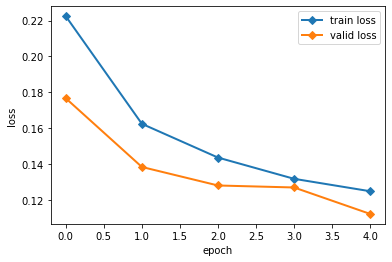

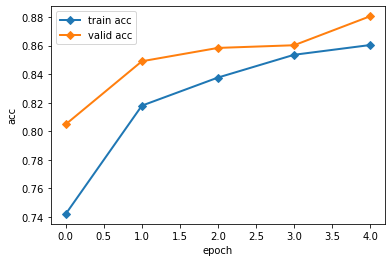

1it [1:04:00, 3840.11s/it]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


In [20]:
if __name__ == "__main__":
    set_random_seed(seed)
    
    # device setting
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("use device: ", device)

    # CV loop
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (train_idx, val_idx) in tqdm(enumerate(folds)):
        time_start = time.time()
        if fold > 0:
            break
        
        # Dataset
        train_filepath2label = dict(zip(train.loc[train_idx, :].image_path, train.loc[train_idx, :].label))
        val_filepath2label = dict(zip(train.loc[val_idx, :].image_path, train.loc[val_idx, :].label))

        train_dataset = CassavaDataset(train_filepath2label, ImageTransform(size, mean, std), 'train', True)
        val_dataset = CassavaDataset(val_filepath2label, ImageTransform(size, mean, std), 'val', True)
        
        # DataLoader
        train_dataloader = get_DataLoader(train_dataset, batch_size, True)
        val_dataloader = get_DataLoader(val_dataset, batch_size, True)
        dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}
        
        # get NetWork model
        use_pretrained = True
        net, update_param_names = get_network(model_name, use_pretrained)
        
        # set train mode
        net.train()

        # criterion
        criterion = get_criterion(loss_name, loss_params)

        # get optimizer
        params_to_update = set_params(net, update_param_names, set_all)
        optimizer = get_optimizer(params_to_update)
        
        # train & valid
        net, epoch_result_dict = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, device)
        
        elapsed_time = time.time() - time_start
        print("Fold{} Running time:{}".format(fold, elapsed_time) + "[sec]")
        
        # plot train & val loss (each epoch)
        figname = make_filename_info('loss', '.png', model_name, fold, loss_name, num_epochs, batch_size, size, set_all)
        plt.plot(range(len(epoch_result_dict['train']['loss'])), epoch_result_dict['train']['loss'], label='train loss', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['loss'])), epoch_result_dict['val']['loss'], label='valid loss', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # plot train & val ACC (each epoch)
        figname = make_filename_info('acc', '.png', model_name, fold, loss_name, num_epochs, batch_size, size, set_all)
        plt.plot(range(len(epoch_result_dict['train']['acc'])), epoch_result_dict['train']['acc'], label='train acc', linewidth=2, marker='D')
        plt.plot(range(len(epoch_result_dict['val']['acc'])), epoch_result_dict['val']['acc'], label='valid acc', linewidth=2, marker='D')
        plt.xlabel('epoch')
        plt.ylabel('acc')
        plt.legend()
        plt.savefig(osp.join('fig', figname))
        plt.show()

        # save model
        filename = make_filename_info('model', '.pth', model_name, fold, loss_name, num_epochs, batch_size, size, set_all)
        save_path = osp.join('trained_model', filename)
        torch.save(net.state_dict(), save_path)

    # prediction for test dataset
    test_datalist = make_datapath_list(rootpath, 'test')
    test_filepath2label = dict(zip(test_datalist, [0] * len(test_datalist)))
    test_dataset = CassavaDataset(test_filepath2label, ImageTransform(size, mean, std), 'test', False)
    test_dataloader = get_DataLoader(test_dataset, batch_size, False)
    
    test_preds = inference_test_data(net, test_dataloader, device)
    
    # make submission.csv
    submission = pd.DataFrame({'image_id': [osp.basename(k) for k in test_datalist], 'label': test_preds})
    submission.to_csv('submission.csv', index=False)